# Optimized Graph Coloring - Efficient Implementation

This notebook implements an optimized approach to graph coloring that combines:
1. Greedy coloring (DSATUR algorithm)
2. Efficient data structures
3. Early termination techniques

In [12]:
import time
import heapq
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict

In [ ]:
def read_graph(filename):
    """
    Read a graph from a file and return it as an adjacency list.
    Optimized for faster processing.
    """
    graph = defaultdict(list)
    
    with open(filename, 'r') as file:
        lines = file.readlines()
        
        parts = lines[0].strip().split()
        num_nodes = int(parts[1])
        
        for line in lines[1:]:
            parts = line.strip().split()
            if parts[0] == 'e':
                node1 = int(parts[1])
                node2 = int(parts[2])
                graph[node1].append(node2)
                graph[node2].append(node1)
    
    return {node: set(neighbors) for node, neighbors in graph.items()}

## Fast Greedy Coloring Algorithm (DSATUR)

DSATUR (Degree of Saturation) is a greedy algorithm that prioritizes coloring nodes based on the number of different colors in their neighborhood.

In [ ]:
def dsatur_coloring(graph, max_colors=None):
    """
    Implement the DSATUR (Degree of Saturation) algorithm for graph coloring.
    - Prioritizes nodes based on their saturation degree (number of differently colored neighbors)
    - Breaks ties by selecting the node with the highest degree
    """
    if not graph:
        return {}
    
    colors = {}                          # Node -> Color assignment
    saturation = {node: 0 for node in graph}  # Node -> Saturation degree
    degrees = {node: len(neighbors) for node, neighbors in graph.items()}  # Node -> Degree
    
    max_degree_node = max(degrees.items(), key=lambda x: x[1])[0]
    
    colors[max_degree_node] = 1
    
    for neighbor in graph[max_degree_node]:
        saturation[neighbor] = 1
    
    while len(colors) < len(graph):
        max_saturation = -1
        selected_node = None
        
        for node in graph:
            if node in colors:  # Skip already colored nodes
                continue
                
            if saturation[node] > max_saturation or \
               (saturation[node] == max_saturation and degrees[node] > degrees.get(selected_node, 0)):
                max_saturation = saturation[node]
                selected_node = node
        
        neighbor_colors = {colors[neighbor] for neighbor in graph[selected_node] if neighbor in colors}
        color = 1
        while color in neighbor_colors:
            color += 1
            # Stop if we exceed max_colors
            if max_colors and color > max_colors:
                return None
        
        colors[selected_node] = color
        
        for neighbor in graph[selected_node]:
            if neighbor not in colors:
                neighbor_of_neighbor_colors = {colors[n] for n in graph[neighbor] if n in colors}
                saturation[neighbor] = len(neighbor_of_neighbor_colors)
    
    return colors

## Fast Backtracking with Pre-Coloring

This implementation starts with a greedy coloring and uses it as an upper bound, then tries to improve with backtracking.

In [ ]:
def fast_graph_coloring(graph, timeout=30):
    """
    Fast graph coloring that combines DSATUR with efficient backtracking.
    Uses a timeout to prevent excessive runtime.
    """
    greedy_coloring = dsatur_coloring(graph)
    
    if not greedy_coloring:
        return None, 0
    
    max_colors_used = max(greedy_coloring.values())
    print(f"Greedy algorithm found a solution with {max_colors_used} colors")
    
    best_coloring = greedy_coloring
    best_colors = max_colors_used
    
    start_time = time.time()
    
    for num_colors in range(max_colors_used-1, 0, -1):
        print(f"Trying with {num_colors} colors...")
        
        if time.time() - start_time > timeout:
            print(f"Timeout reached after {timeout} seconds. Best solution so far: {best_colors} colors.")
            break
            
        try_coloring = optimized_backtracking(graph, num_colors, start_time, timeout)
        
        if try_coloring:
            best_coloring = try_coloring
            best_colors = num_colors
        else:
            # If we couldn't find a coloring with this many colors, we're done
            break
    
    return best_coloring, best_colors

In [ ]:
def optimized_backtracking(graph, num_colors, start_time, timeout):
    """
    Optimized backtracking with:
    - Normal operations for neighbor color checking
    - Pre-coloring high-degree nodes first
    - MRV (Minimum Remaining Values) heuristic
    - Forward checking
    - Early termination on timeout
    """
    sorted_nodes = sorted(graph.keys(), key=lambda node: len(graph[node]), reverse=True)
    colors = {}
    
    available_colors = {node: set(range(1, num_colors + 1)) for node in graph}
    
    def update_available_colors(node, color, is_assignment):
        """Update available colors for neighbors when assigning/unassigning a color"""
        for neighbor in graph[node]:
            if neighbor not in colors:  # Only update uncolored neighbors
                if is_assignment:
                    if color in available_colors[neighbor]:
                        available_colors[neighbor].remove(color)
                else:
                    can_add_back = True
                    for n_neighbor in graph[neighbor]:
                        if n_neighbor in colors and colors[n_neighbor] == color:
                            can_add_back = False
                            break
                    if can_add_back:
                        available_colors[neighbor].add(color)
    
    def select_next_node():
        """Select the node with minimum remaining values (fewest available colors)"""
        min_choices = float('inf')
        selected_node = None
        
        for node in sorted_nodes:
            if node not in colors:
                num_choices = len(available_colors[node])
                if num_choices < min_choices:
                    min_choices = num_choices
                    selected_node = node
                    if num_choices == 0:
                        break
        
        return selected_node
    
    def backtrack():
        if time.time() - start_time > timeout:
            return False
            
        if len(colors) == len(graph):
            return True
        
        node = select_next_node()
        
        if len(available_colors[node]) == 0:
            return False
        
        for color in sorted(list(available_colors[node])):  # Use a sorted list for deterministic behavior
            colors[node] = color
            update_available_colors(node, color, True)  # Forward checking
            
            if backtrack():
                return True
            
            # Backtrack
            colors.pop(node)
            update_available_colors(node, color, False)  # Undo forward checking
        
        return False
    
    if len(graph) > 50:  # Only for large graphs
        precolor_count = len(graph) // 5
        for node in sorted_nodes[:precolor_count]:
            neighbor_colors = {colors[neighbor] for neighbor in graph[node] if neighbor in colors}
            color = 1
            while color in neighbor_colors and color <= num_colors:
                color += 1
            
            if color > num_colors:
                return None
                
            colors[node] = color
            update_available_colors(node, color, True)
    
    if backtrack():
        return colors
    else:
        return None

## Utility Functions

In [ ]:
def print_coloring(colors):
    """
    Print the coloring solution in a readable format.
    """
    if colors is None:
        print("No valid coloring found.")
        return
    
    num_colors_used = max(colors.values())
    
    print(f"Valid coloring found using {num_colors_used} colors:")
    
    color_groups = defaultdict(list)
    for node, color in colors.items():
        color_groups[color].append(node)
    
    for color in range(1, num_colors_used + 1):
        nodes = color_groups.get(color, [])
        if nodes:  # Only print non-empty color groups
            if len(nodes) > 20:
                print(f"Color {color}: {len(nodes)} nodes, including {sorted(nodes[:5])}...")
            else:
                print(f"Color {color}: {sorted(nodes)}")

def visualize_graph_coloring(graph, colors, title, max_nodes=50):
    """
    Visualize the graph with its coloring using networkx and matplotlib.
    Limit to max_nodes for readability.
    """
    if len(graph) > max_nodes:
        nodes_by_degree = sorted(graph.keys(), key=lambda n: len(graph[n]), reverse=True)
        sample_nodes = set(nodes_by_degree[:max_nodes])
        
        subgraph = {}
        for node in sample_nodes:
            subgraph[node] = {n for n in graph[node] if n in sample_nodes}
        
        graph_to_plot = subgraph
        title = f"{title} (showing {max_nodes} highest-degree nodes)"
    else:
        graph_to_plot = graph
    
    G = nx.Graph()
    
    for node, neighbors in graph_to_plot.items():
        G.add_node(node)
        for neighbor in neighbors:
            G.add_edge(node, neighbor)
    
    color_map = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
                '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5']
    
    node_colors = [color_map[(colors[node] - 1) % len(color_map)] for node in G.nodes()]
    
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G, seed=42)  # For consistent layout
    nx.draw(G, pos, node_color=node_colors, with_labels=True, node_size=500, font_weight='bold')
    plt.title(title)
    plt.show()

## Testing the Fast Algorithm on Each Dataset

In [ ]:
def process_test_file(filename, timeout=60):
    """
    Process a test file with the optimized algorithm and timeout.
    """
    print(f"\n=== Processing {filename} with Fast Algorithm (timeout: {timeout}s) ===")
    
    start_time = time.time()
    graph = read_graph(filename)
    print(f"Graph has {len(graph)} nodes and {sum(len(neighbors) for node, neighbors in graph.items())//2} edges")
    
    coloring, chromatic_number = fast_graph_coloring(graph, timeout)
    
    execution_time = time.time() - start_time
    if coloring:
        print(f"Chromatic number is {chromatic_number}")
        print(f"Execution time: {execution_time:.2f} seconds")
        
        print_coloring(coloring)
        
        is_valid = True
        for node, neighbors in graph.items():
            node_color = coloring[node]
            for neighbor in neighbors:
                if coloring[neighbor] == node_color:
                    is_valid = False
        
        if is_valid:
            print("✓ Coloring is valid!")
        
        visualize_graph_coloring(graph, coloring, f"Graph Coloring for {filename} (Chromatic Number: {chromatic_number})")
    else:
        print(f"Timeout.")

### Test 1 - Optimized Algorithm


=== Processing test1.txt with Fast Algorithm (timeout: 120s) ===
Graph has 138 nodes and 493 edges
Greedy algorithm found a solution with 11 colors
Trying with 10 colors...
Chromatic number is 11
Execution time: 0.00 seconds
Valid coloring found using 11 colors:
Color 1: 39 nodes, including [18, 30, 37, 54, 106]...
Color 2: 45 nodes, including [9, 29, 36, 78, 120]...
Color 3: 21 nodes, including [7, 21, 59, 89, 95]...
Color 4: [64, 74, 77, 79, 93, 100, 103, 104, 118]
Color 5: [51, 72, 92, 94, 130, 136]
Color 6: [6, 26, 73, 76, 138]
Color 7: [19, 20, 45, 83, 101, 108, 116]
Color 8: [33, 135]
Color 9: [85, 99]
Color 10: [81]
Color 11: [91]
✓ Coloring is valid!


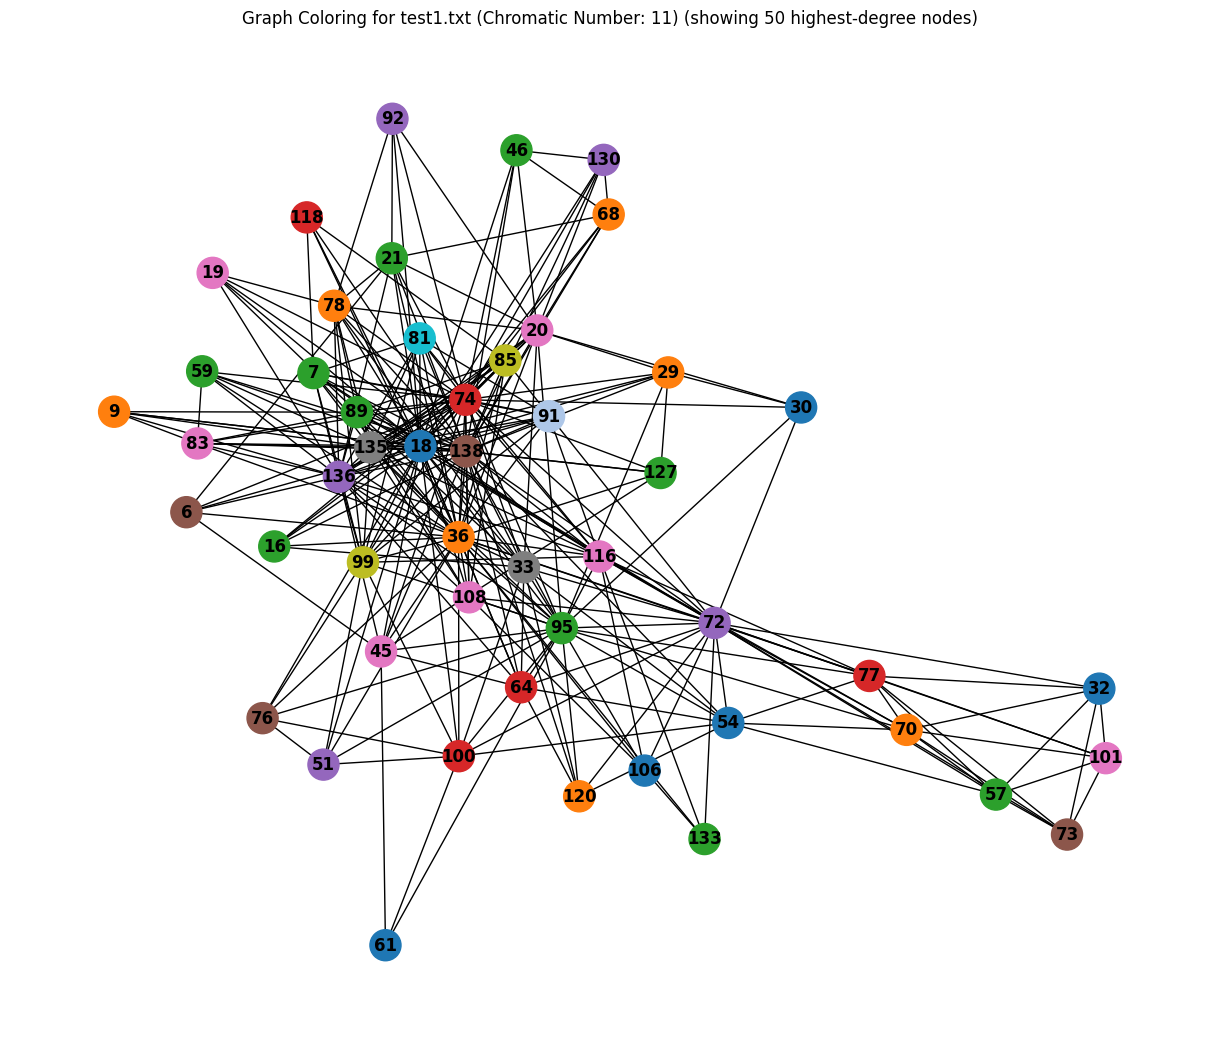

In [19]:
process_test_file('test1.txt', timeout=120)

### Test 2 - Optimized Algorithm


=== Processing test2.txt with Fast Algorithm (timeout: 120s) ===
Graph has 500 nodes and 62624 edges
Greedy algorithm found a solution with 65 colors
Trying with 64 colors...
Trying with 63 colors...
Greedy algorithm found a solution with 65 colors
Trying with 64 colors...
Trying with 63 colors...
Trying with 62 colors...
Trying with 62 colors...
Chromatic number is 63
Execution time: 126.75 seconds
Valid coloring found using 63 colors:
Color 1: [35, 102, 111, 201, 238, 326, 400, 440]
Color 2: [1, 14, 17, 90, 151, 429, 455, 470, 498]
Color 3: [37, 65, 173, 221, 288, 363, 410, 442, 471]
Color 4: [4, 71, 86, 136, 180, 302, 416, 500]
Color 5: [31, 156, 183, 228, 251, 336]
Color 6: [43, 54, 132, 170, 207, 215, 248, 344]
Color 7: [34, 97, 153, 158, 300, 301, 328, 441]
Color 8: [66, 113, 135, 138, 161, 329, 435]
Color 9: [9, 47, 141, 191, 212, 280, 347, 355, 430]
Color 10: [106, 229, 231, 256, 284, 323, 367, 463, 478]
Color 11: [3, 41, 159, 192, 195, 234, 247, 421, 480]
Color 12: [91, 92, 1

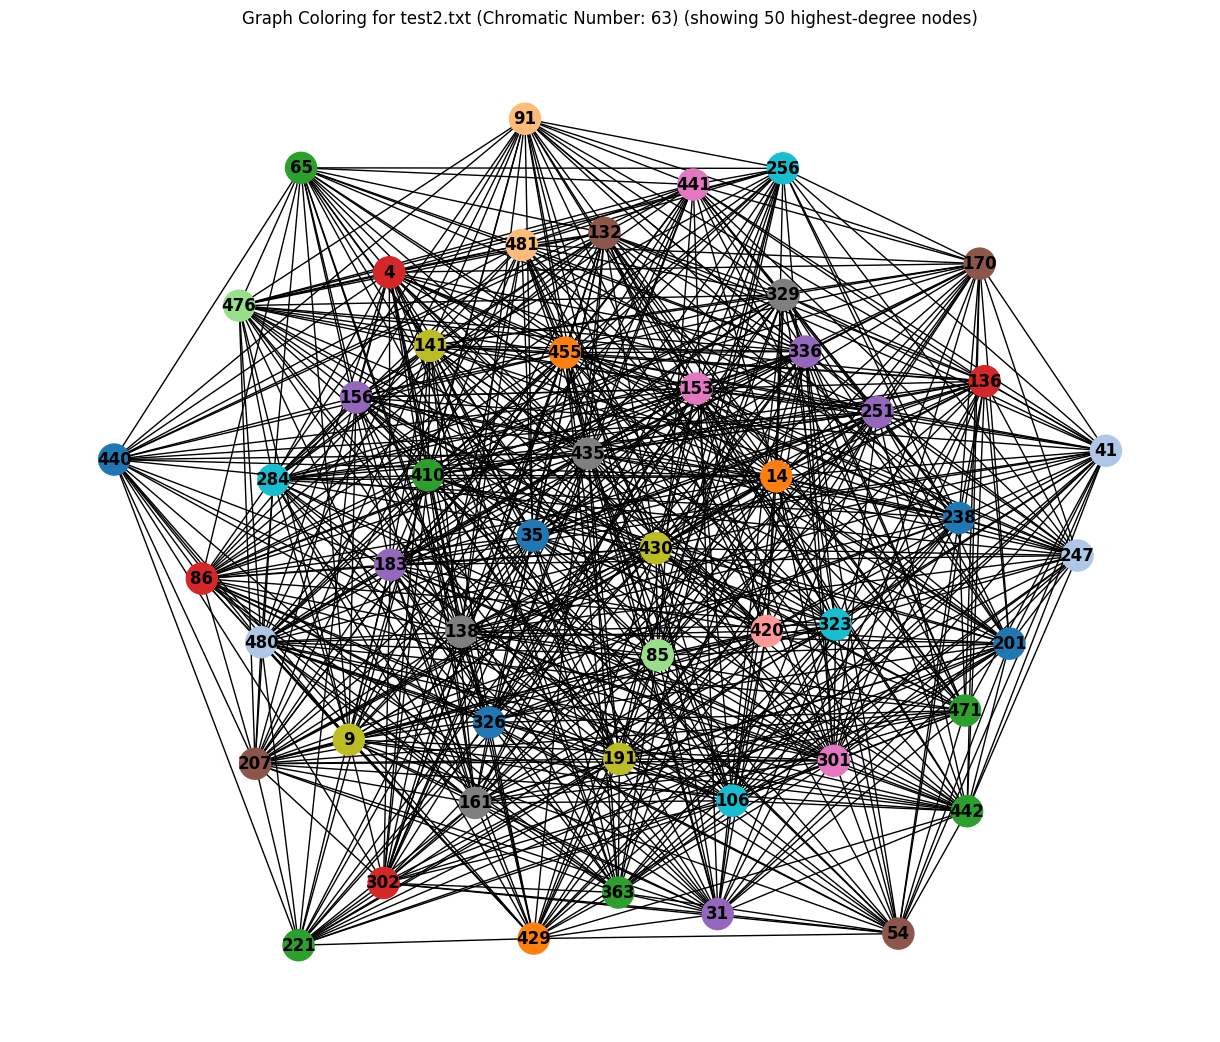

In [20]:
process_test_file('test2.txt', timeout=120)

### Test 3 - Optimized Algorithm


=== Processing test3.txt with Fast Algorithm (timeout: 120s) ===
Graph has 1000 nodes and 246708 edges
Graph has 1000 nodes and 246708 edges
Greedy algorithm found a solution with 115 colors
Trying with 114 colors...
Trying with 113 colors...
Trying with 112 colors...
Greedy algorithm found a solution with 115 colors
Trying with 114 colors...
Trying with 113 colors...
Trying with 112 colors...
Chromatic number is 113
Execution time: 247.27 seconds
Valid coloring found using 113 colors:
Color 1: [192, 288, 345, 395, 467, 633, 694, 946, 952, 970]
Color 2: [17, 290, 350, 400, 573, 597, 752, 762, 803, 953]
Color 3: [35, 88, 120, 130, 135, 412, 478, 665, 834]
Color 4: [16, 139, 253, 256, 264, 343, 390, 674, 842, 962]
Color 5: [29, 171, 299, 366, 465, 654, 719, 816, 899]
Color 6: [118, 126, 314, 414, 430, 528, 671, 924, 939]
Color 7: [1, 76, 81, 131, 342, 354, 456, 689, 845, 854]
Color 8: [189, 404, 500, 515, 524, 527, 615, 655, 847]
Color 9: [10, 32, 52, 86, 164, 195, 277, 283, 441, 699, 8

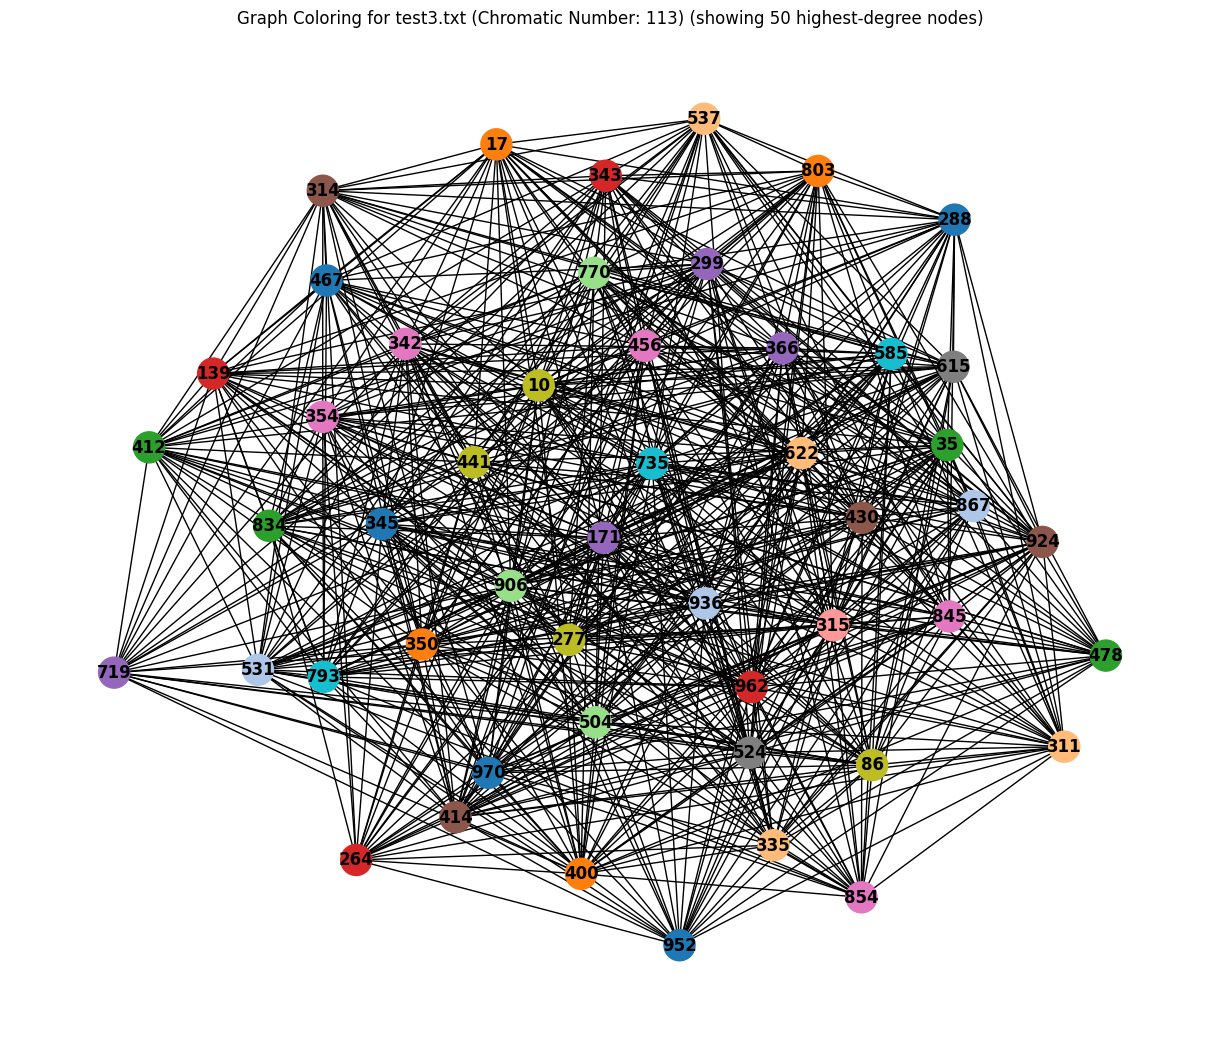

In [21]:
process_test_file('test3.txt', timeout=120)

### Test 4 - Optimized Algorithm


=== Processing test4.txt with Fast Algorithm (timeout: 120s) ===
Graph has 900 nodes and 307350 edges
Graph has 900 nodes and 307350 edges
Greedy algorithm found a solution with 130 colors
Trying with 129 colors...
Greedy algorithm found a solution with 130 colors
Trying with 129 colors...
Chromatic number is 130
Execution time: 133.74 seconds
Valid coloring found using 130 colors:
Color 1: [1, 99, 182, 273, 378, 461, 552, 714, 805, 831]
Color 2: [2, 91, 185, 274, 380, 473, 562, 644, 733, 860]
Color 3: [3, 94, 181, 272, 391, 479, 570, 668, 759, 821]
Color 4: [4, 97, 271, 403, 491, 578, 699, 785, 857]
Color 5: [5, 187, 414, 502, 588, 719, 804, 876]
Color 6: [6, 92, 417, 510, 598, 653, 741, 859]
Color 7: [7, 189, 428, 522, 607, 675, 760, 895]
Color 8: [8, 96, 183, 275, 439, 526, 618, 688, 780, 842]
Color 9: [9, 278, 443, 537, 630, 737, 863]
Color 10: [10, 103, 195, 287, 364, 456, 548, 672, 764, 872]
Color 11: [11, 102, 196, 285, 381, 475, 564, 664, 753, 880]
Color 12: [12, 100, 197, 288

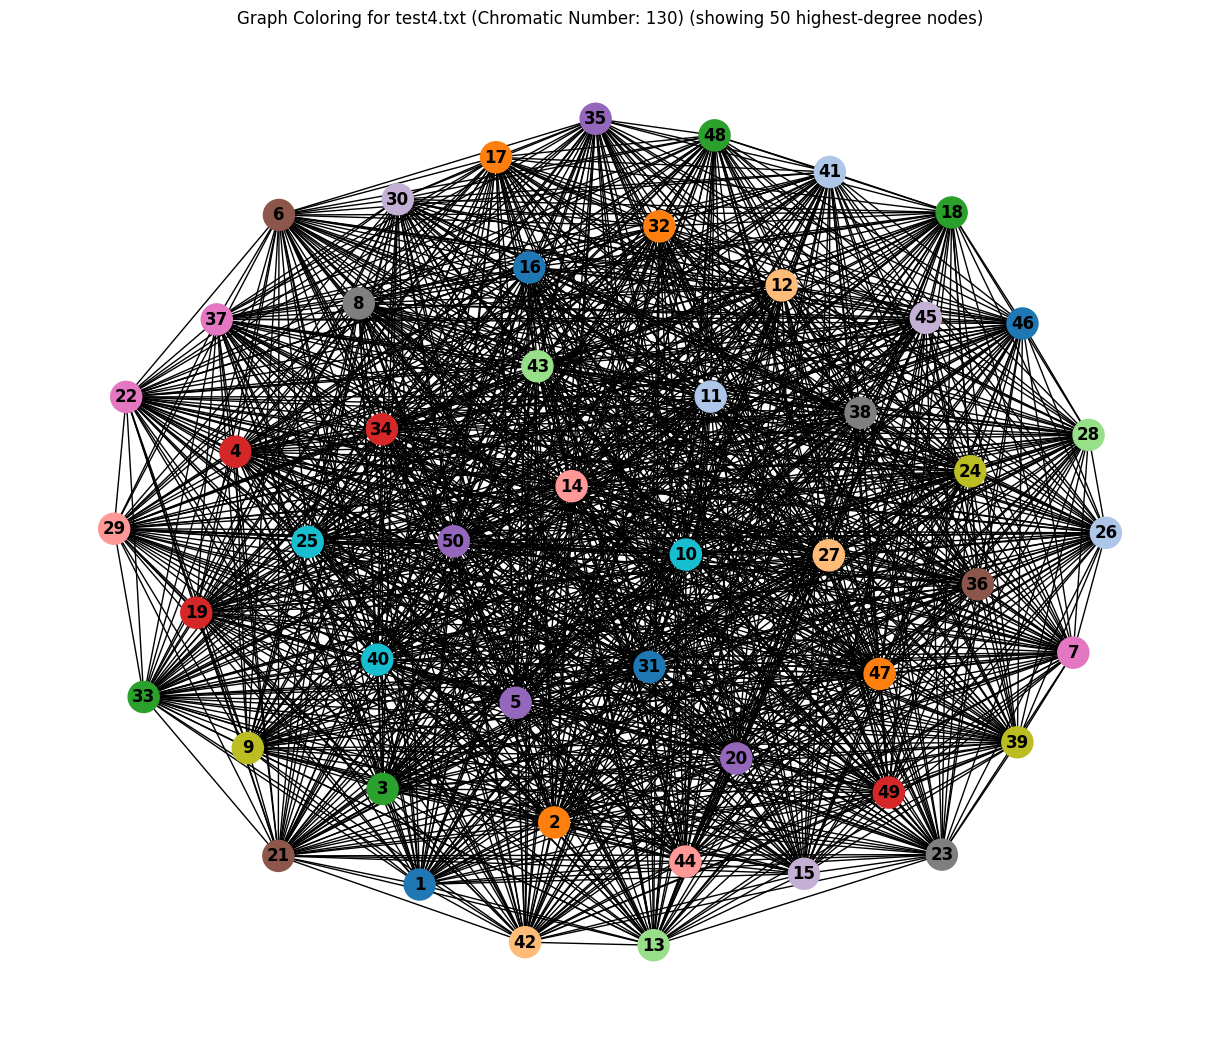

In [22]:
process_test_file('test4.txt', timeout=120)